# TOXIC DETECTOR

In [1]:
import os
import pathlib

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

# General
from tqdm import tqdm
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Device Setting
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


### Import Tokenizer from huggingface


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
!pip install datasets tokenizers

# Huggingface
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import BertTokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00


# Configuration

In [4]:
def get_config(num_epochs, vocab_size):
  return{
      "train_batch_size": 8,
      "test_batch_size": 1,
      "num_epochs": num_epochs,
      "lr": 3e-4,
      "seq_len": 256,
      "d_model": 256,
      "h": 4,
      "depth" : 2,
      "dropout": 0.2,
      "num_classes": vocab_size,
      "checkpoint": 'bert-base-uncased'
  }



# Data
1. Kaggle: jigsaw-toxic-comment-classification-challenge



In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
os.chmod('/content/kaggle.json', 600)

!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!unzip jigsaw-toxic-comment-classification-challenge.zip
!unzip test.csv.zip
!unzip train.csv.zip
!unzip test_labels.csv


 93% 49.0M/52.6M [00:00<00:00, 117MB/s] 
100% 52.6M/52.6M [00:00<00:00, 91.9MB/s]
Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test_labels.csv.zip
  inflating: test_labels.csv         


In [6]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')

print(f"Toxic rate:\n{train['toxic'].value_counts(normalize=True)}\n")
print(f"Toxic rate:\n{train['severe_toxic'].value_counts(normalize=True)}\n")
print(f"Toxic rate:\n{train['obscene'].value_counts(normalize=True)}\n")
print(f"Toxic rate:\n{train['threat'].value_counts(normalize=True)}\n")
print(f"Toxic rate:\n{train['insult'].value_counts(normalize=True)}\n")
print(f"Toxic rate:\n{train['identity_hate'].value_counts(normalize=True)}\n")



Toxic rate:
toxic
0    0.904156
1    0.095844
Name: proportion, dtype: float64

Toxic rate:
severe_toxic
0    0.990004
1    0.009996
Name: proportion, dtype: float64

Toxic rate:
obscene
0    0.947052
1    0.052948
Name: proportion, dtype: float64

Toxic rate:
threat
0    0.997004
1    0.002996
Name: proportion, dtype: float64

Toxic rate:
insult
0    0.950636
1    0.049364
Name: proportion, dtype: float64

Toxic rate:
identity_hate
0    0.991195
1    0.008805
Name: proportion, dtype: float64



### Balancing & Split into train, val

In [7]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv')

non_toxic = data[data['toxic']==0]
toxic = data[(data['severe_toxic'] == 1) | (data['obscene'] == 1) | (data['threat'] == 1)| (data['insult'] == 1)| (data['identity_hate'] == 1)]

print(f"# of non toxic data: {len(non_toxic)}, \n# of toxic data: {len(toxic)}\n")

non_toxic = resample(non_toxic,
                     replace=False,
                     n_samples=len(toxic) * 2,
                     random_state=123)

dataset = pd.concat([toxic, non_toxic])
X = dataset['comment_text']
y = dataset['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))



# of non toxic data: 144277, 
# of toxic data: 10559

toxic
0    0.695829
1    0.304171
Name: proportion, dtype: float64
toxic
0    0.69697
1    0.30303
Name: proportion, dtype: float64


In [ ]:
# toxic.head()
# header = ["comment_text"]
# toxic.to_csv('toxic.csv', columns = header, index=False)

### Tokenizer examples

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vocab_size = tokenizer.vocab_size
config = get_config(10, vocab_size)
print(f'Pre-trained Tokenizer below: \n {tokenizer}')

texts = list(X_train.values[:5])
encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
input_ids = encoded_inputs['input_ids']
token_type_ids = encoded_inputs['token_type_ids']
attention_mask = encoded_inputs['attention_mask']
print(f'Input Ids: {input_ids}')
print(f'Token type Ids: {token_type_ids}')
print(f'Attention masks: {attention_mask}')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Pre-trained Tokenizer below: 
 BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
Input Ids: tensor([[  101,  7592,  1010,  1045,  2134,  1005,  1056,  3972, 12870,  2009,
         

### Create Dataset

In [9]:
from torch.utils.data import Dataset

class BERTDataset(Dataset):
  def __init__(self, text, toxic, config):
    super().__init__()

    self.txt = text.values
    self.y = toxic.values

    self.seq_len = config['seq_len']
    self.h = config['h']
    self.tokenizer = BertTokenizer.from_pretrained(config['checkpoint'])

  def __len__(self):
    return len(self.txt)

  def __getitem__(self, idx):
    source = str(self.txt[idx])
    target = self.y[idx]

    h = self.h
    seq_len = self.seq_len

    # tokenized_source
    tokenized_source = self.tokenizer(source,
                                     max_length = self.seq_len,
                                     padding='max_length',
                                     truncation = True
                                     )

    encoder_input = torch.tensor(tokenized_source['input_ids'], dtype= torch.long)

    # mask
    encoder_mask = torch.tensor(tokenized_source['attention_mask'], dtype= torch.long).unsqueeze(0)
    encoder_mask = encoder_mask.repeat(1, h, 1)
    encoder_mask = encoder_mask.expand(seq_len, h, seq_len)
    encoder_mask = encoder_mask.transpose(0,1).contiguous()

    item = {
          'txt': source,
          'encoder_input': encoder_input,
          'encoder_mask': encoder_mask,
          'target': target
    }

    return item

### DataLoader

In [10]:

train_loader = DataLoader(
    BERTDataset(X_train, y_train, config),
    batch_size = config['train_batch_size'],
    shuffle=True,
    pin_memory = True
)

test_loader = DataLoader(
    BERTDataset(X_test, y_test, config),
    batch_size = config['test_batch_size'],
    shuffle=True,
    pin_memory = True
)

dataiter = iter(train_loader)
batch = next(dataiter)
for idx in range(len(batch['encoder_input'])):
  print(f"encoder_input: {batch['encoder_input'][idx]}")
  print(f"encoder_mask: {batch['encoder_mask'][idx].size()}")
  print(f"target: {batch['target'][idx]}")

dataiter = iter(test_loader)
batch = next(dataiter)
for idx in range(len(batch['encoder_input'])):
  print(f"encoder_input: {batch['encoder_input'][idx]}")
  print(f"encoder_mask: {batch['encoder_mask'][idx].size()}")
  print(f"target: {batch['target'][idx]}")

encoder_input: tensor([ 101, 1012, 1045, 1005, 2222, 2191, 2204, 5857, 1065, 1065,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,

# Ready to build Transformer
For Toxic classification, we only need encoder blocks.

1. Input Embedding
2. Positional Encoding
3. Feed Forward
4. Multi-Head Attention
5. Encoder block
6. Transformer


### Input Embedding + Positional Encoding

In [11]:
import math

class InputEmbedding(nn.Module):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.vocab_size = vocab_size
    self.d_model = d_model
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embedding(x) * (self.d_model ** 0.5)


class PositionalEmbedding(nn.Module):
  def __init__(self, d_model, seq_len):
    super().__init__()

    pe = torch.zeros(seq_len, d_model)

    pos = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000) / d_model))

    pe[:, 0::2] = torch.sin(pos*div)
    pe[:, 1::2] = torch.cos(pos*div)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:, :x.shape[1], :].requires_grad_(False)
    return x


### Input Embedding + Positional Embedding Example

In [12]:
tokenizer = BertTokenizer.from_pretrained(config['checkpoint'])
print(tokenizer)

input_embedding = InputEmbedding(tokenizer.vocab_size, config['d_model'])
positional_encoding = PositionalEmbedding(config['d_model'], config['seq_len'])

train_ds = BERTDataset(X_train, y_train, config)
data = train_ds.__getitem__(1)

encoder_input = data['encoder_input']
print(f"Source ids: {encoder_input}")
print(f"Source ids size: {encoder_input.size()}")

src_emb = input_embedding(encoder_input.unsqueeze(0))
print(f"\nSource after embedded size: {src_emb.size()}")
src_pe = positional_encoding(src_emb)
print(f"Source after positional embedded size: {src_pe.size()}\n")
print(f"Source after positional embedding: {src_pe}\n")

val_ds = BERTDataset(X_test, y_test, config)
data = val_ds.__getitem__(1)

encoder_input = data['encoder_input']
print(f"Source ids: {encoder_input}")
print(f"Source ids size: {encoder_input.size()}")

src_emb = input_embedding(encoder_input.unsqueeze(0))
print(f"\nSource after embedded size: {src_emb.size()}")
src_pe = positional_encoding(src_emb)
print(f"Source after positional embedded size: {src_pe.size()}\n")
print(f"Source after positional embedding: {src_pe}\n")



BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
Source ids: tensor([ 101, 6616, 2017, 2017, 2643, 4365, 2388, 6616, 2378, 2365, 1997, 1037,
        7743, 2644, 2108, 1037, 5236, 

### Feed Forward
- Following "Attention is all you need", we need each of the layers in encoder and decoder to contain a fully connected feed-forward network, which is applied to each position separately and identically. It consists of two linear transformations with a ReLU activation in between.

$FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$

- $d_{model} = 256$, and the inner-layer has dimensionality $d_{ff} = d_{model} * 4$

In [13]:
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.d_model = config['d_model']
    self.d_ff = self.d_model * 4

    self.ffn = nn.Sequential(
        nn.Linear(self.d_model, self.d_ff),
        nn.ReLU(),
        nn.Linear(self.d_ff, self.d_model),
        nn.Dropout(config['dropout'])
    )

  def forward(self, x):
    return self.ffn(x)


## Multi-Head Attention

In [14]:
class MultiHeadAttention(nn.Module):
  def __init__(self, config):
    super(MultiHeadAttention, self).__init__()

    self.d_model = config['d_model']
    self.h = config['h']

    assert self.d_model % self.h == 0, "d_model must be divisible by h"


    self.d_k = self.d_model // self.h
    # Query, key, value
    self.W_q = nn.Linear(self.d_model, self.d_model, bias=False)
    self.W_k = nn.Linear(self.d_model, self.d_model, bias=False)
    self.W_v = nn.Linear(self.d_model, self.d_model, bias=False)

    # Last Layer
    self.W_o = nn.Linear(self.d_model, self.d_model, bias=False)

    # dropout
    self.dropout = nn.Dropout(config['dropout'])

  def forward(self, q, k, v, mask):
    # input size: torch.Size([B, seq_len, d_model])
    B, Seq_len, d_model = q.size()

    h = self.h
    d_k = self.d_k
    d_model = self.d_model

    query = self.W_q(q)
    key = self.W_k(k)
    value = self.W_v(v)

    # size: (Batch, Seq_len, d_model) -> (Batch, Seq_len, h, d_model // h)
    query = query.view(B, Seq_len, h, d_k)
    key = key.view(B, Seq_len, h, d_k)
    value = value.view(B, Seq_len, h, d_k)

    # (Batch, Seq_len, h, d_k) -> (Batch, h, Seq_len, d_k)
    # (Batch, h, Seq_len, d_k) -> (Batch * h, Seq_len, d_k)
    query = query.transpose(1,2).contiguous().view(B * h, Seq_len, d_k)
    key = key.transpose(1,2).contiguous().view(B * h, Seq_len, d_k)
    value = value.transpose(1,2).contiguous().view(B * h, Seq_len, d_k)

    # paying attention to each sequences, therefore size should be (Batch *h, Seq_len, Seq_len)
    W = query @ key.transpose(1,2)
    W = W / (d_model ** 0.5)

    if mask is not None:
      mask = mask.view(B * h, Seq_len, Seq_len)
      W = W.masked_fill(mask == 0, float("-inf"))

    W = W.softmax(dim = -1)
    # drop out
    W = self.dropout(W)

    out = W @ value # (B * h, seq_len, d_k)
    out = out.view(B, h, Seq_len, d_k)
    out = out.transpose(1,2).contiguous().view(B, Seq_len, h * d_k)
    return self.W_o(out)


### Encoder Block

In [15]:
class EncoderBlock(nn.Module):
  def __init__(self, config):
    super(EncoderBlock, self).__init__()

    self.d_model = config['d_model']

    self.MultiHeadAttention = MultiHeadAttention(config)
    self.ln_1 = nn.LayerNorm(self.d_model)
    self.ln_2 = nn.LayerNorm(self.d_model)
    self.FeedForward = FeedForward(config)

  def forward(self, x, mask):
    x = x + self.MultiHeadAttention(x, x, x, mask)
    x = self.ln_1(x)
    x = x + self.FeedForward(x)
    x = self.ln_2(x)
    return x


# Toxic Detector

In [16]:
class ToxicDetector(nn.Module):
  def __init__(self, config, vocab_size):
    super(ToxicDetector, self).__init__()
    self.d_model = config['d_model']
    self.seq_len = config['seq_len']
    self.num_classes = config['num_classes']
    self.depth = config['depth']

    # Input Embedding, Positional Embedding
    self.emb = InputEmbedding(vocab_size, self.d_model)
    self.pe = PositionalEmbedding(self.d_model, self.seq_len)

    # Encoder: blocks of encoder blocks
    self.Encoder = nn.ModuleList([
        EncoderBlock(config) for _ in range(self.depth)
    ])
    self.Encoder = nn.Sequential(*self.Encoder)
    self.mlp = nn.Linear(self.d_model, self.num_classes)

  def forward(self, x, mask):
    x = self.pe(self.emb(x))

    for block in self.Encoder:
      x = block(x, mask)
    x = x.mean(dim=1)
    x = self.mlp(x)
    # return x
    return torch.log_softmax(x, dim=1)




# Checking dimension

In [17]:
d_model = config['d_model']
seq_len = config['seq_len']
num_classes = config['num_classes']
depth = config['depth']

# Input Embedding, Positional Embedding
emb = InputEmbedding(tokenizer.vocab_size, d_model).to(device)
pe = PositionalEmbedding(d_model, seq_len).to(device)

# Encoder: blocks of encoder blocks
Encoder = nn.ModuleList([
    EncoderBlock(config) for _ in range(depth)
  ]).to(device)

mlp = nn.Linear(d_model, num_classes).to(device)

dataiter = iter(train_loader)
batch = next(dataiter)

encoder_input = batch['encoder_input'].to(device)
encoder_mask = batch['encoder_mask'].to(device)
target = batch['target'].to(device)

x = pe(emb(encoder_input))
for block in Encoder:
  x = block(x, encoder_mask)
print(x.size())
x = x.mean(dim=1)
print(x.size())
x = mlp(x)
print(f'after mlp: {x.size()}')
print(x.size())
print(x)
# val, ind = torch.max(x, dim=1)
# print(val)
# print(ind.to(torch.float32))
print(target)
ce =nn.CrossEntropyLoss()
#bce = nn.BCELoss()
print(ce(x, target))


torch.Size([8, 256, 256])
torch.Size([8, 256])
after mlp: torch.Size([8, 30522])
torch.Size([8, 30522])
tensor([[-1.8200e-01,  4.6107e-02, -3.9012e-02,  ..., -2.5340e-01,
          2.6558e-01,  7.1535e-02],
        [-1.1600e-01, -7.1456e-02, -1.5482e-01,  ..., -3.8553e-01,
          4.6397e-01,  2.2247e-01],
        [-9.5621e-02,  1.6429e-02, -5.6369e-02,  ...,  4.8239e-02,
          2.3930e-01,  8.0889e-02],
        ...,
        [-1.2665e-01,  3.4088e-01, -1.0651e-01,  ..., -1.1123e-01,
          4.5237e-01,  1.1991e-01],
        [-1.0307e-01, -1.1331e-01,  9.6593e-02,  ..., -1.7539e-01,
          4.4430e-01, -1.7870e-01],
        [-1.1976e-01,  1.4888e-01, -8.9710e-02,  ..., -1.3151e-01,
          4.9298e-01,  4.0974e-04]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
tensor(10.5512, device='cuda:0', grad_fn=<NllLossBackward0>)


# Train & Validate TOXIC DETECTOR

{'train_batch_size': 8, 'test_batch_size': 1, 'num_epochs': 10, 'lr': 0.0003, 'seq_len': 256, 'd_model': 256, 'h': 4, 'depth': 2, 'dropout': 0.2, 'num_classes': 30522, 'checkpoint': 'bert-base-uncased'}
ToxicDetector(
  (emb): InputEmbedding(
    (embedding): Embedding(30522, 256)
  )
  (pe): PositionalEmbedding()
  (Encoder): Sequential(
    (0): EncoderBlock(
      (MultiHeadAttention): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=False)
        (W_k): Linear(in_features=256, out_features=256, bias=False)
        (W_v): Linear(in_features=256, out_features=256, bias=False)
        (W_o): Linear(in_features=256, out_features=256, bias=False)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (FeedForward): FeedForward(
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=1024, 

Processing epoch 00: 100%|██████████| 3168/3168 [01:40<00:00, 31.40it/s, loss=0.065]


1, Loss: 0.06


Processing epoch 01: 100%|██████████| 3168/3168 [01:40<00:00, 31.65it/s, loss=0.256]


2, Loss: 0.26


Processing epoch 02: 100%|██████████| 3168/3168 [01:40<00:00, 31.68it/s, loss=0.039]


3, Loss: 0.04


Processing epoch 03: 100%|██████████| 3168/3168 [01:40<00:00, 31.56it/s, loss=0.010]


4, Loss: 0.01


Processing epoch 04: 100%|██████████| 3168/3168 [01:39<00:00, 31.74it/s, loss=0.019]


5, Loss: 0.02


Processing epoch 05: 100%|██████████| 3168/3168 [01:39<00:00, 31.76it/s, loss=0.006]


6, Loss: 0.01


Processing epoch 06: 100%|██████████| 3168/3168 [01:40<00:00, 31.57it/s, loss=0.049]


7, Loss: 0.05


Processing epoch 07: 100%|██████████| 3168/3168 [01:39<00:00, 31.73it/s, loss=0.002]


8, Loss: 0.00


Processing epoch 08: 100%|██████████| 3168/3168 [01:40<00:00, 31.54it/s, loss=0.123]


9, Loss: 0.12


Processing epoch 09: 100%|██████████| 3168/3168 [01:40<00:00, 31.64it/s, loss=0.001]


10, Loss: 0.00


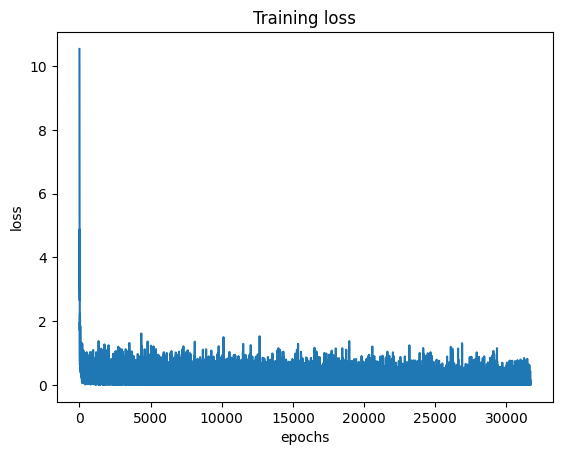

Precision: [0.94112319 0.91927083]
Recall: [0.96404547 0.87160494]
F-1 score: [0.95244643 0.89480355]


In [18]:
# path for saving model
path = "./ToxicDetector"
pathlib.Path(f"./{path}/").mkdir(parents=True, exist_ok=True)

# configuration
config = get_config(10, vocab_size)
print(config)

# hyperparameter
num_epochs = config['num_epochs']
lr = config['lr']

# tokenizer
tokenizer = BertTokenizer.from_pretrained(config['checkpoint'])
vocab_size = tokenizer.vocab_size

# loss, optim, model
model = ToxicDetector(config, vocab_size).to(device)
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
print(model)

Loss = []

# TRAINING
for epoch in range(num_epochs):
  model.train()
  batch_iterator = tqdm(train_loader, desc = f'Processing epoch {epoch:02d}')
  for batch in batch_iterator:
    encoder_input = batch['encoder_input'].to(device)
    encoder_mask = batch['encoder_mask'].to(device)
    target = batch['target'].to(device)

    out = model(encoder_input, encoder_mask)
    # out = out.squeeze()
    # if ids.size()[0] != config['train_batch_size']:
    #   out = out.unsqueeze(0)
    loss = ce_loss(out, target)
    # _, pred = torch.max(out, dim=1)
    # pred = pred.to(torch.float32)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    batch_iterator.set_postfix(loss=f"{loss.item():6.3f}")
    Loss.append(loss.item())
  print(f"{epoch+1}, Loss: {loss.item():.2f}")
  torch.save(model.state_dict(), f'{path}/{epoch}.pth')

torch.save(model.state_dict(), f'{path}/td_final_model_2_4_256.pth')

# Loss plot
plt.plot(Loss, linestyle='-')
plt.title('Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

preds = []
targets = []
#validation
with torch.no_grad():
  correct = 0
  total = 0
  model.eval()
  for idx, batch in enumerate(test_loader, 0):
    total += batch['encoder_input'].size()[0]

    encoder_input = batch['encoder_input'].to(device)
    encoder_mask = batch['encoder_mask'].to(device)
    target = batch['target'].to(device)
    out = model(encoder_input, encoder_mask)
    _, pred = torch.max(out, dim=1)
    preds.extend(pred)
    targets.extend(target)

preds = [p.cpu().numpy() for p in preds]
targets = [t.cpu().numpy() for t in targets]

print(f"Precision: {precision_score(preds, targets, average=None)}")
print(f"Recall: {recall_score(preds, targets, average=None)}")
print(f"F-1 score: {f1_score(preds, targets, average=None)}")

# TEST

In [19]:
dataiter = iter(test_loader)

In [ ]:
for a in range(100):
  batch = next(dataiter)

  txts = batch['txt']
  encoder_input = batch['encoder_input'].to(device)
  encoder_mask = batch['encoder_mask'].to(device)
  target = batch['target'].to(device)
  out = model(encoder_input, encoder_mask)

  _, pred = torch.max(out, dim=1)

  for i in range(len(txts)):
    print(f"Predicted: {pred[i]}")
    print(f"Target: {target[i]}")
    print('\n')



In [75]:
#@title Leaves a comment.

comment = "Type here to test 'Toxic Detector' model" #@param {type: "string"}

h = config['h']
seq_len = config['seq_len']

tokenized_source = tokenizer(comment, max_length = seq_len, padding='max_length', truncation=True, return_tensors='pt').to(device)
encoder_input = tokenized_source['input_ids']

encoder_mask = torch.tensor(tokenized_source['attention_mask'], dtype= torch.long).unsqueeze(0)
encoder_mask = encoder_mask.repeat(1, h, 1)
encoder_mask = encoder_mask.expand(seq_len, h, seq_len)
encoder_mask = encoder_mask.transpose(0,1).contiguous()


out = model(encoder_input, encoder_mask)
_, pred = torch.max(out, dim=1)
print(pred)

h = config['h']
seq_len = config['seq_len']



tensor([0], device='cuda:0')
